In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import unicodedata

from bs4 import BeautifulSoup
import requests
import time
from IPython.core.display import display, HTML

from os import listdir
from os.path import isfile, join
from tqdm import tqdm, tqdm_notebook

# Import Review DB

In [90]:
df_review = pd.read_csv("./ratebeer2.csv", encoding = "latin-1", names=["ids", "name","review"])
df_review.head(2)

,ids,name,review
0,1,Beamish Irish Stout,The nitro really does disservice to the beer. ...
1,100,Nutfield Auburn Ale,I thought this was a nice well balanced beer. ...


In [91]:
df_review['name'] = [i.replace('&#40;', "") if '&#40;' in i else i for i in df_review.name  ]
df_review['name'] = [i.replace('&#41;', "") if '&#41;'in i else i for i in df_review.name  ]

In [92]:
def normalize_name(name): 
    uni = re.sub('[()]', '', str(name)) #remove parenthesis
    uni = re.sub('[^a-zA-Z0-9áéíóúÁÉÜÍÓÚüâäèêîôÂÊÎÔãõñÃÕçÇ: ]', ' ', uni) #remove special characters except accents
    uni = uni.lower().strip()
    nfkd_form = unicodedata.normalize('NFKD', uni)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    name_norm = only_ascii.decode('utf-8')
    return name_norm

In [93]:
def build_link(df):
    lst_link = []
    for index, row in df.iterrows():
        join_name = "+".join(row['name'].split(' '))
        link = "/beer/"+join_name+"/"+str(row['ids'])+"/"
        lst_link.append(link)
    return lst_link

In [94]:
df_review.name = df_review.name.apply(normalize_name)
df_review.review = df_review.review.apply(normalize_name)

In [95]:
df_review['link'] = build_link(df_review)

In [96]:
df_review.ids = pd.to_numeric(df_review['ids'], errors='coerce', downcast='integer')

In [109]:
df_review = df_review.dropna(axis=0, how='any')

In [113]:
df_review.ids = df_review.ids.astype(int)

In [114]:
df_review.head()

,ids,name,review,link
0,1,beamish irish stout,the nitro really does disservice to the beer ...,/beer/beamish+irish+stout/1/
1,100,nutfield auburn ale,i thought this was a nice well balanced beer ...,/beer/nutfield+auburn+ale/100/
2,10000,dithmarscher pilsener,its a typical north german pilsner but has a ...,/beer/dithmarscher+pilsener/10000/
3,100001,partners anglo dutch aspistus,cask at cloisters edinburgh light golden a...,/beer/partners+anglo+dutch+aspistus/100001/
4,100009,golden city javapeno imperial stout,on tap at boulder strong ale fest poured an op...,/beer/golden+city+javapeno+imperial+stout/100009/


In [115]:
df_review.shape

(87244, 4)

# Import Original DB

In [116]:
df_rb = pd.read_csv('./ratebeer_dataset_2.csv')
df_rb=df_rb.rename(columns = {'id':'ids'})
df_rb.head(2)

,name,score,beer style,abv,cal,city,country,link,ids
0,Ivanych Zhivoe Svetloe,2.84,Zwickel/Keller/Landbier,4.5,135.0,Sukhum,Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/,301247
1,Stara Praha Oldenburg Tiemnoye,2.52,Dunkel/Tmavý,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/,334787


In [117]:
df_rb.name = df_rb.name.apply(normalize_name)

In [118]:
df_rb.head()

,name,score,beer style,abv,cal,city,country,link,ids
0,ivanych zhivoe svetloe,2.84,Zwickel/Keller/Landbier,4.5,135.0,Sukhum,Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/,301247
1,stara praha oldenburg tiemnoye,2.52,Dunkel/Tmavý,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/,334787
2,stara praha oldenburg svetloe,2.51,Pale Lager,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-svetloe/334785/,334785
3,stara praha oldenburg jantarnoye,2.49,Amber Lager/Vienna,4.5,135.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-jantarnoye/334786/,334786
4,assir lager svetloe,2.37,Pale Lager,5.0,150.0,Alakhadzykh Village Gagra Region,Abkhazia,/beer/assir-lager-svetloe/191169/,191169


In [119]:
df_rb.shape

(5006, 9)

# Merge data

In [120]:
df_rb_id = df_rb.set_index('ids')
df_rb_id.head(2)

,name,score,beer style,abv,cal,city,country,link
ids,,,,,,,,
301247,ivanych zhivoe svetloe,2.84,Zwickel/Keller/Landbier,4.5,135.0,Sukhum,Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/
334787,stara praha oldenburg tiemnoye,2.52,Dunkel/Tmavý,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/


In [121]:
df_rev_id = df_review.set_index('ids')
df_rev_id.head(2)

,name,review,link
ids,,,
1,beamish irish stout,the nitro really does disservice to the beer ...,/beer/beamish+irish+stout/1/
100,nutfield auburn ale,i thought this was a nice well balanced beer ...,/beer/nutfield+auburn+ale/100/


In [122]:
df_id = pd.concat([df_rb_id, df_rev_id], axis=1, join='inner')

In [123]:
df_id.shape

(681, 11)

In [124]:
df_rb_name = df_rb.set_index('name')
df_rb_name.head(2)

,score,beer style,abv,cal,city,country,link,ids
name,,,,,,,,
ivanych zhivoe svetloe,2.84,Zwickel/Keller/Landbier,4.5,135.0,Sukhum,Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/,301247
stara praha oldenburg tiemnoye,2.52,Dunkel/Tmavý,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/,334787


In [125]:
df_rev_name = df_review.set_index('name')
df_rev_name.head(2)

,ids,review,link
name,,,
beamish irish stout,1,the nitro really does disservice to the beer ...,/beer/beamish+irish+stout/1/
nutfield auburn ale,100,i thought this was a nice well balanced beer ...,/beer/nutfield+auburn+ale/100/


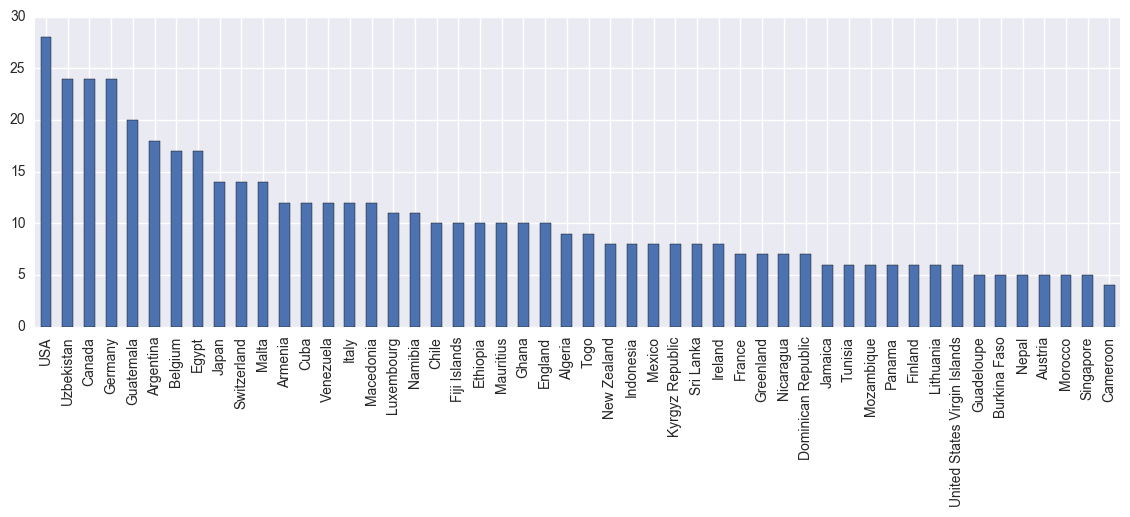

In [127]:
df_id.country.value_counts()[:50].plot(kind='bar', figsize=(14,4))